<a href="https://colab.research.google.com/github/murilopo/Data_Science_Projects/blob/master/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Detecção de Fraude em Cartões de Crédito**

>Levantamento da Federação Brasileira de Bancos (Febraban) mostrou o crescimento de tentativas de fraudes financeiras contra os brasileiros durante a pandemia de covid-19. Neste período, as instituições registraram **aumento de 80% nas tentativas de ataques** de phishing – que se inicia por meio de recebimento de emails que carregam vírus ou links e que direcionam o usuário a sites falsos.



<center><img width ="75%" src = "https://raw.githubusercontent.com/murilopo/Project_Imagens/master/Wallet%20ilustation.jpg"></center>

Como pode ser lido na reportagem da *Agencia Brasil* - ([Neste link](https://agenciabrasil.ebc.com.br/geral/noticia/2020-09/federacao-de-bancos-alerta-para-aumento-de-fraudes-durante-pandemia)):
A pandemia do corona virus proporcionou um aumento de 80% no número de fraudes financeiras, entre eles 60% dos casos contra idosos. Dentre as tentativas de fraudes se encontram diversas abordagens telefônicas para identificação de dados pessoais das vítimas.

Muitas vezes uma ligação não é necessária para fraudes financeiras. Isso pode ser conferido na reportagem da tecnolog sobre denuncias de fraudes em cartões de crédito à [Nubank](https://tecnoblog.net/349140/exclusivo-clientes-nubank-denunciam-fraude-compras-cartao-credito/) . As denúncias surgiram devido o aparecimento de uma cobrança indevida em diversos clientes, de mesmo valor e com o mesmo nome de comprador. A Nubank assim como outras intituições financeiras tem excelentes sistemas de segurança que impedem que os dados dos clientes sejam vazados, assim como informado na reportagem a Nubank utiliza a localização do telefone celular para evitar fraudes eletrônicas.



Conforme toda a problemática do tema que [*Em 2019 as fraudes financeiras acarretaram um prejuizo de R$1,8 bilhão em 12 meses*](https://extra.globo.com/noticias/economia/fraudes-financeiras-geraram-um-prejuizo-de-cerca-de-18-bilhao-em-12-meses-23908141.html). A ideia deste `notebook` é o utilizar a aplicação de Data Science e Machine Learning para verificar se é possivel identificar fraudes financeiras em um banco de dados de uma instituição financeira.






## Importando os Dados.

O conjuntos de dados que será utilizados contêm transações realizadas por cartões de crédito em setembro de 2013 por titulares de cartões europeus.
Este conjunto de dados contêm transações que ocorreram em dois dias, para tal  temos 492 fraudes em 284.807 transações. O conjunto de dados é altamente desbalanceado, a classe positiva (fraudes) é responsável por 0,172% de todas as transações.

Outro detalhe sobre o conjunto de dados é que ele contém apenas variáveis ​​de entrada numéricas que são o resultado de uma *transformação PCA*. Devido a questões de confidencialidade, não foi fornecido os `features` originais. Portatando o nome das colunas foram apresentadas como $[V1, V2,… V28]$.

A [Transforamação PCA](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf) é uma maneira de identificar a relação entre caracteristica extraidas de dados. Neste caso como uma transação tem elevada caracteristicas(dezenas de colunas) a transformação PCA consiste em diminuir a dimensionalidade das `features` e tranforma em dimensões menores, mantendo todas as informações neste dado. A consequencia é a criação das `features` $[V1, V2,… V28]$ .


In [1]:
#@title
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Instalar a biblioteca Scikit-plot
!pip install -q Scikit-plot


In [2]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

Para facilitar a aquisição dos dados, criei um link com acesso direto ao csv. Com isso, basta importar o conjunto de dados usando o método: 
> pd.read_csv().

In [3]:
# Importar os dados para Data Frame. 

df = pd.read_csv("https://www.dropbox.com/s/0gmthw4vlgzs94d/creditcard.csv?dl=1")

Após importar o banco de dados que será trabalhado e não havendo a necessidade de nenhum ajuste. Pode-se iniciar a `anàlise exploratória`. 

## Análise Exploratória

Nas 5 primeiras linhas podemos constatar o seguinte:

- Dezenas de `features`descaracterizadas [V1,V2,... V28] devido a transforamação PCA.
- Coluna `Time`e `Amount`foram preservadas, mantendo a configuração original.
- Variável Alvo `Class`
   - 0 Transação Normal
   - 1 Transação com Fraude





In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Será utilizado o método `describe`para idetificar as descrições estátisticas dos dados coletados. Assim pode-se analisar de forma macro como os dados estão dispersos.

Conclui-se no dataframe após a aplicação do método que: 

- Tem-se 284807.0 Entradas  
- Campo **"Amount"**, valor de cada transferência, possui: 
 - Média = €88,0 
 - Mediana = €22,0 
 - Desvio Padrão = €250
---

Com base no resultado de Desvio padrão tão elevado conclui-se que temos dados muito dispersos em nosso data frame, então será necessário diminuir a dispersão para aplicar metódos de Machile Learning


In [5]:
# Ver Resumo estátistico

df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Para a próxima análise será verificado a **qualidade** do Dado trabalhado. Para isso analiza-se a existencia de valores ausente. 

**Não ha valores ausentes que precisam ser tratados**

In [6]:
# Verificar se existe valor nulo no DataSet. 

df.isnull().sum().max()

0

A próxima etapa é verificarmos se a variavel alvo $"Class"$ está balanceada.

A necessidade de fazer essa análise é que variáveis alvos não balanceadas impedem bons resultados na aplicação de Machine Learning. Ou seja a aprendizagem de máquina não consegue relacionar as variaveis importadas e classificar as transações como Normais ou Fraudulentas.

> Mais a frente será exemplicado a diferença entre a matriz de correlação com dados balanceados e não balanceados.

**Como Balancear os dados ?**

É possivél aplicando de forma básica e com bons resultados *$Oversamplim$* ou *$Undersampling$* - [Link para estudo](https://medium.com/data-hackers/como-lidar-com-dados-desbalanceados-em-problemas-de-classifica%C3%A7%C3%A3o-17c4d4357ef9). Isso será feito mais a frente.

Por ora será analisado graficamente as discrepâncias entre as transações normais e as fraudulentas. 


0    284315
1       492
Name: Class, dtype: int64

 O numero de Fraude representam 0.173% do dataset.



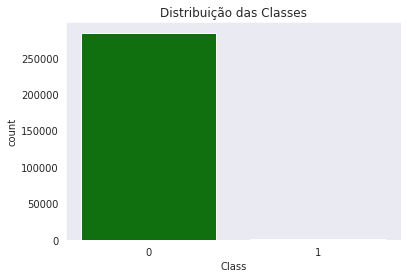

In [7]:
# Classificação da classe "Class"
print(df.Class.value_counts())
print("\n O numero de Fraude representam {:.3f}% do dataset.\n".format((df[df.Class == 1].shape[0])/(df.Class.shape[0])*100))

# Plotar o Gráfico de Barras com as classes. 

fig, ax = plt.subplots()
sns.countplot("Class",data=df,ax=ax,color= 'g')
ax.set_title('Distribuição das Classes')
plt.plot();

Nitidamente percebe-se acima o quão desbalanceado está este dataset, para tal precisa-se balancear antes de realizar o estudo.

Será analisado agora se existe alguma correlação com o horário do número de fraudes com o de transferências eletrônica normal.Plotou-se então dois gráficos a fim de comparar as distribuições das 2 classes(0 e 1) ao longo da dimensão tempo (Time).No entanto, não foi identificada nenhuma informação a partir das distribuições de frequência abaixo.

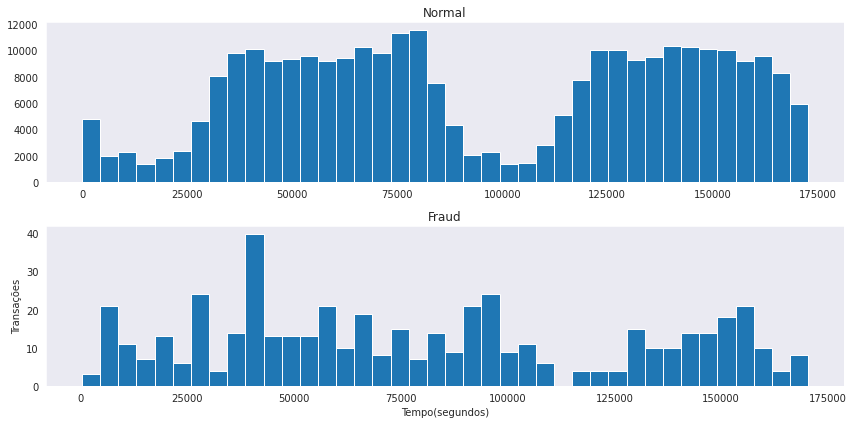

In [8]:
fig, ax = plt.subplots(nrows=2,ncols = 1,figsize =(12,6))

n_bins = 40

ax[0].hist(df.Time[df.Class == 0],bins=n_bins)
ax[0].set_title("Normal")

ax[1].hist(df.Time[df.Class == 1],bins=n_bins)
ax[1].set_title("Fraud")

plt.xlabel('Tempo(segundos)')
plt.ylabel('Transações')
plt.tight_layout()


O próximo passo na análise exploratória é entender a dispersão dos dados da variável `amount`. Para tal plotou-se um $boxplot$ para analisar se há alguma diferença no padrão de transações.

Percebe-se que existem distribuições diferentes para as duas classe. Provavelmente irá contribuir para o treinamento do modelo de Machine Learning.



count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


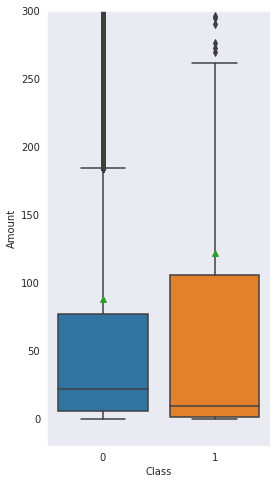

In [9]:
fig,ax = plt.subplots(figsize=(4,8),sharex= True) 

sns.boxplot(df.Class,df.Amount,ax=ax,showmeans = True)

plt.ylim(-20,300)

print(df[df.Class == 1].Amount.describe())

Estatisticamente tivemos o seguinte resultado para a variável Class == 1, cuja é a que nos interessa.

- Média = €122
- Mediana = €9,25
- Desvio Padrão = €240,0





In [10]:
df[df.Class == 1].Amount.describe() 

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Finalizando a análise exploratória falta entendermos se existe uma relação entre as `fetures` de transferências normais(Class = 0) e Fraudes (Class =1)

**Qual a melhor forma de fazer isto ?**

Será aplicado o *gráfico de densidade*. Muito utilizado quando temos muitos pontos que não podem ser analisados com gráfico de frequência.Neste caso será muito útil para compararmos as distribuições de cada variável para cada classe e ver quais as mais importantes para detecção de anomalias.

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente. Veja como exemplo as variáveis **V3, V4, V10 e V11**, como elas são bem distintas.

Por outro lado, variáveis como **V8, V13, V15, V20 e V23** são muito similares, apresentando aproximadamente o mesmo comportamento.



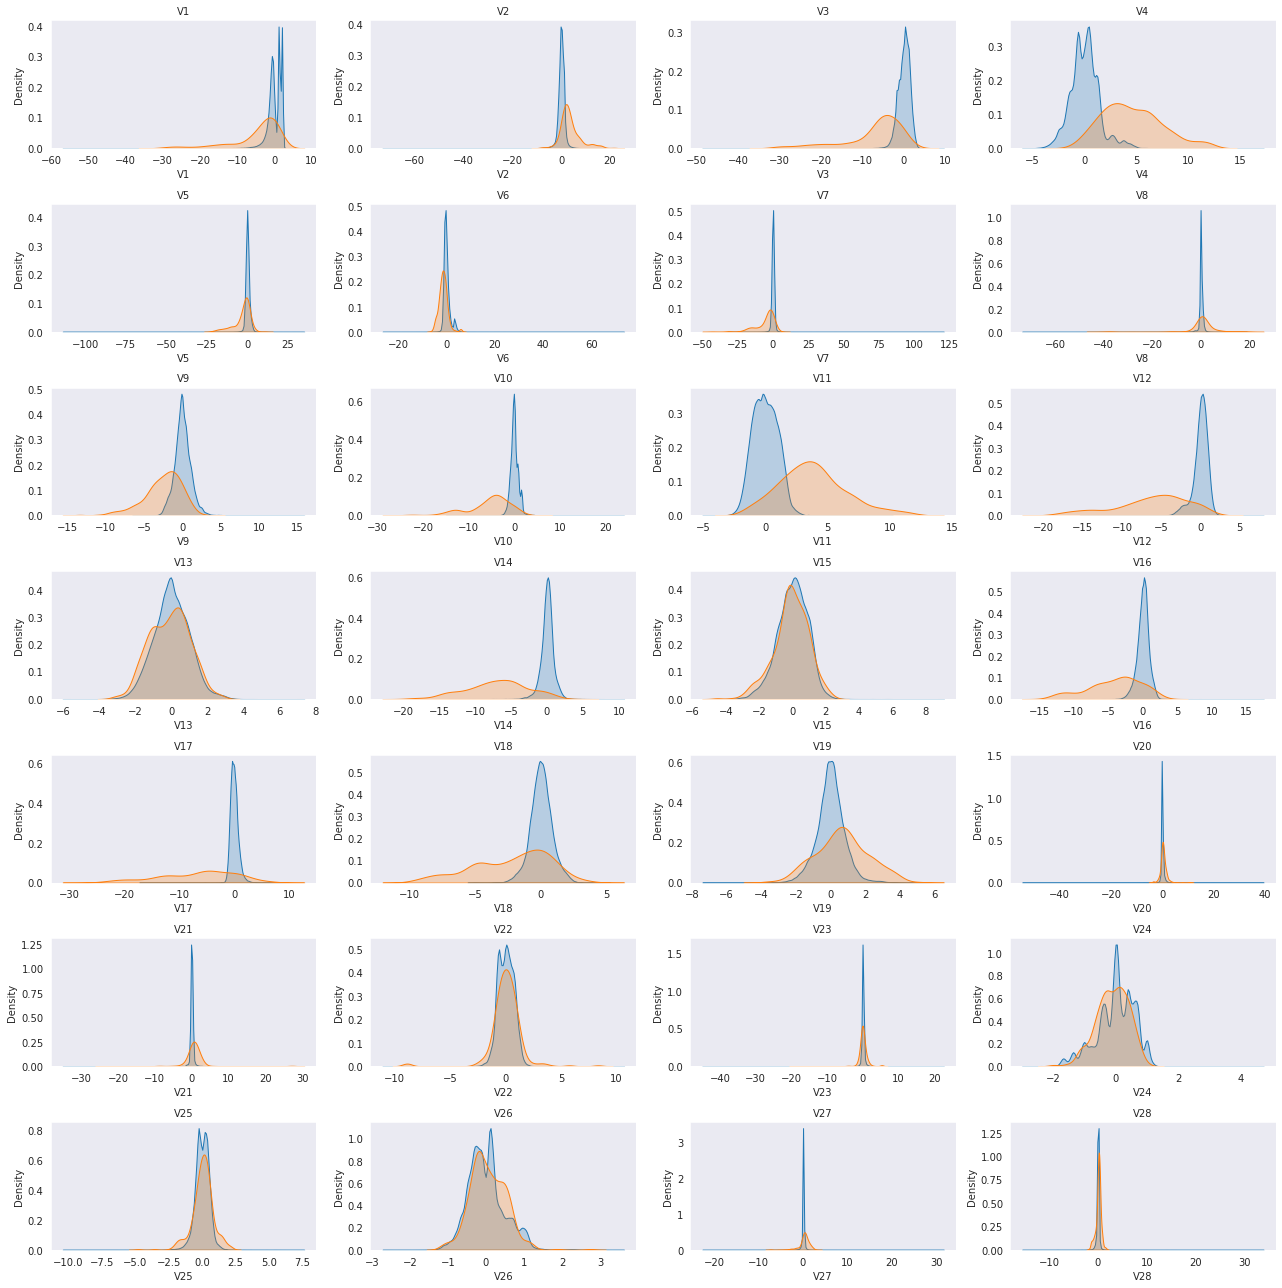

In [11]:
column_names = df.drop(['Class','Amount','Time'],axis=1).columns # Colunas restantes
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig,ax = plt.subplots(nrows=7,ncols=4,figsize=(18,18))
fig.subplots_adjust(hspace=1,wspace=1)


idx = 0
for col in column_names:
  idx += 1
  plt.subplot(7,4, idx)
  sns.kdeplot(df_class_0[col],label="Class 0",shade= True)
  sns.kdeplot(df_class_1[col],label="Class 1",shade= True)
  plt.title(col, fontsize = 10)
plt.tight_layout()



Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O dataset está muito **desbalanceado**, uma vez que as transações fraudulentas representam apenas **0,17%** das entradas totais.
* Não existem valores ausentes ou nulos no dataframe.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as features originais foram padronizadas.
* As colunas Time e Amount não estão normalizadas.

## Preparando Dados

Será utilizado o Modelo de classificação [Regressão Logistica](https://medium.com/turing-talks/turing-talks-14-modelo-de-predi%C3%A7%C3%A3o-regress%C3%A3o-log%C3%ADstica-7b70a9098e43) ele irá nos fornecer o seguinte análise: **Qual a probabilidade desta transferência ser Normal ou uma Fraude?** 

Para que os dados possam alimentar o modelo de Regressão Logística que iremos construir, nesta etapa de preparação iremos: 

* Padronizar as features Time e Amount, que estão em outra ordem de grandeza.
* Dividir entre dados de treino e teste
* Balancear os dados a fim de evitar uma baixa performance para a classe 1 e overfitting.

**Padronizar `Time` e `Amount`**

Para esta etapa, uma vez que a coluna `Amount` possui *outliers* será usada a padronização por meio da classe `StandardScaler`. 


Vale destacar que equação utilizada pelo `StandardScaler` para calcular os *scores* é $z = \frac{x-u}{s}$, onde $u$ é a média das amostras do conjunto de treino e $s$ é o desvio padrão dessa amostra.

`StandardScaler` estátisticamente serve para remover a multidisproporcionalidade dos dados. aplica-se a subtração dos desvios e divisão do desvio Padrão. Método transforma a variável em um range de -1 á 1.  



In [12]:
# Padronizar Time e Amount.

df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


**Dividir entre conjuntos de Treino e Teste**.

Antes de proceder com o balanceamento de dados, devemos splitar os dados já existentes entre treino e teste. Caso contrário, não teremos parâmetros para conferir se o balanceamento foi adequado.

Para garantir que os conjuntos de treino e teste tenham a mesma quantidade de classes proporcionalmente, passamos **stratify=True**.







In [13]:
# Separar Variaveis entre X e Y. 

X = df_clean.drop('Class',axis=1)
y = df['Class']

# Dividir o dataset entre Treino e teste.
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y, shuffle= True)

**Balanceamento dos Dados**

Para banlancear os dados usarei a biblioteca $imblearn$.É possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar **Under-sampling**, preservando a classe minoritária.

É fácil ver que não há mais aquela discrepância inicial (gráfico de barras no início deste notebook).


1    369
0    369
dtype: int64


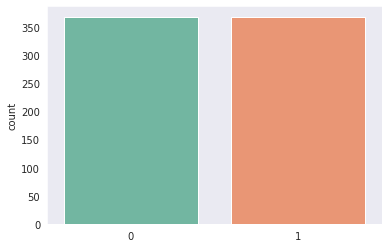

In [14]:
# Usar Tecnica Under-sampling. 

rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_sample(X_train, y_train)

# Ver o balanceamento de classe. 
print(pd.Series(y_rus).value_counts())

#plotar a nova distribuição de classes. 
sns.countplot(y_rus,palette= "Set2");


Com os dados balanceados, podemos ver a matriz de correlação e identificar quais variáveis estão mais fortemente relacionadas com as outras. Na matriz de correlação quanto mais próximo de 1 maior a relação entre as variáveis.

Observe a esquerda, sem o balanceamento de dados, a matriz de correlação não traria nenhuma informação relevante. Entretanto, ela traz muito mais informações após um correto balanceamento.

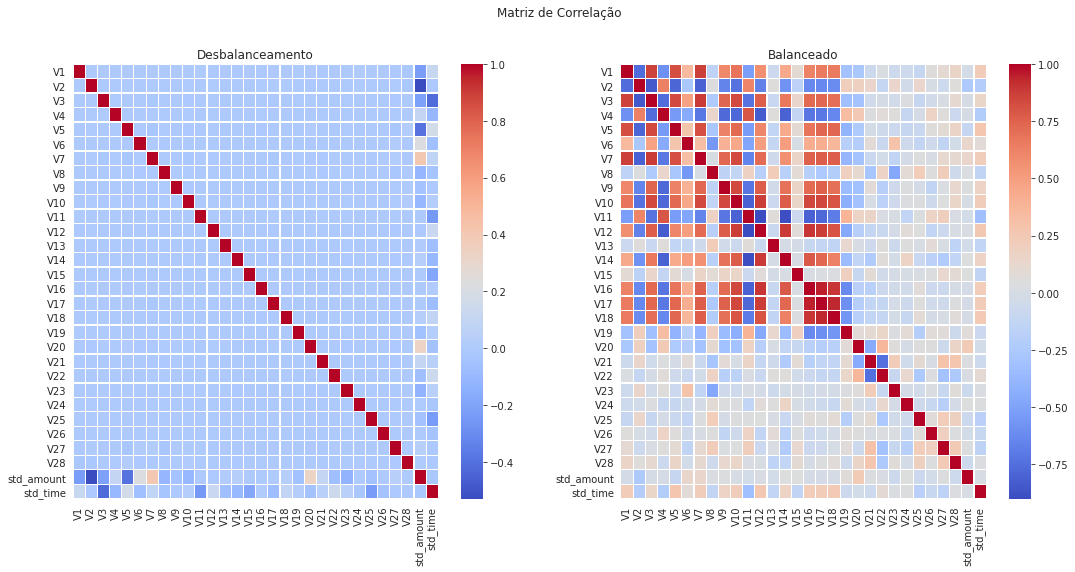

In [15]:
# Plotar Matriz de Correlação

corr =  X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (18,8))
fig.suptitle("Matriz de Correlação")

sns.heatmap(corr,xticklabels= corr.columns,yticklabels=corr.columns,
            linewidths = .1,cmap = "coolwarm",ax=ax[0])
ax[0].set_title('Desbalanceamento')

sns.heatmap(corr_rus,xticklabels= corr.columns,yticklabels=corr.columns,
            linewidths = .1,cmap = "coolwarm",ax=ax[1])

ax[1].set_title('Balanceado')
plt.show()


Por exemplo no grafico a direita podemos ver alto indice de relação entre as varáiveis V1 com V3,V5, V7 e V10. 

##Modelo de Machine Learning

Com todos os dados preparados e após uma análise exploratória completa, irei construir um classificador usando a Regressão Logística,como informado anteriormente.

Após instanciar o modelo, o mesmo será treinado em cima dos dados em X_rus e y_rus(Variáveis de treino após balanceamento). Na sequência, serão realizadas as previsões sobre os dados de teste.

In [16]:
# Instanciar e treinar um modelo de regressão logistica.

np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus,y_rus)

#Fazer previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho.

Neste tipo de problema, originalmente desbalanceado, a acurácia não é uma métrica adequada. Como explicado neste [artigo](https://medium.com/@vitorborbarodrigues/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-recall-quais-as-diferen%C3%A7as-c8f05e0a513c), você pode ter uma acurácia de 99,88% e não conseguir detectar fraude como é o objetivo do projeto.

Agora Observe a matriz de confusão para ver a taxa de acertos para transações fraudulentas, ou pela coluna recall do Relatório de Classificação.


Uma outra métrica considerada interessante para avaliar a eficácia é a AUC ROC, ou área sob a curva. No caso desse modelo de Regressão Logística, tem-se 95% de [AUC](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772).

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9646    0.9819     71079
           1     0.0433    0.9268    0.0828       123

    accuracy                         0.9645     71202
   macro avg     0.5216    0.9457    0.5324     71202
weighted avg     0.9982    0.9645    0.9804     71202

Acurácia: 0.9645

AUC: 0.9457



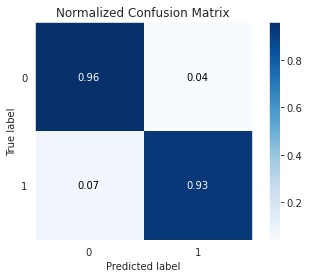

In [17]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))


## Resultados

A utilização deste modelo de machine learning junto com a pré processamento dos dados explicados passo-a-passo alcançou o seguinte resultado.

Acurácia de 96,5% - De todos os dados foi possivel classificar corretamente 96,5 %. Esse indice não representa a o que se deseja.

**97 de acerto** para Classificação de Transferência como **normais** e **erro de 3%** 

**93% de acerto** para Classificação de Transferência **Fraudes** e erro de 7%.

## Conclusões

Como você pode observar, não se trata de um problema trivial. Apesar dos dados estarem bem tratados e limpos, sem valores ausentes ou variáveis categóricas, o desbalanceamento e a Transformação PCA demandaram um trabalho considerável.

Obviamente, apesar do bom resultado final, há espaço para testar o desempenho com outros algoritmos de classificação ou de metodologia mais avançada de balanceamento, afim de otimizar os parametros finais do modelo.
